<a href="https://colab.research.google.com/github/Bowen-Leee/clip-multimodal-ml/blob/main/CLIP_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[参考博客](https://towardsdatascience.com/clip-model-and-the-importance-of-multimodal-embeddings-1c8f6b13bf72)
[参考github项目地址](https://github.com/RustamyF/clip-multimodal-ml)

CLIP: Contrastive Language-Image Pretraining, is a deep learning model developed by OpenAI in 2021.

CLIP的应用:

1.   图像分类与检索
2.   内容审核

CLIP的主要两个组件:

1.   图像编码器: 可以是Resnet, ViT
2.   文本编码器: 可以是CBOW, BERT, or Text Transformer

原论文模型中图像编码器，文本编码器没有初始化参数，这里基于resnet，distilbert预训练参数进行训练

训练过程中，模型接收一批图像和对应的文本描述。对于每一对图像和文本描述，模型会分别计算图像特征和文本特征，并使用对比损失来最小化它们之间的距离，同时最大化与非对应样本之间的距离。




In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
     

In [ ]:
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
import torch
# Define a custom dataset class for Flickr30k
class Flickr30kDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.dataset = load_dataset("nlphuji/flickr30k", cache_dir="./huggingface_data")
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        self.cap_per_image = 2

    def __len__(self):
        return self.dataset.num_rows["test"] * self.cap_per_image

    def __getitem__(self, idx):
        original_idx = idx // self.cap_per_image
        image = self.dataset["test"][original_idx]["image"].convert("RGB")
        image = self.transform(image)

        # labels
        caption = self.dataset["test"][original_idx]["caption"][idx % self.cap_per_image]

        return {"image": image, "caption": caption}

# Create an instance of the custom dataset
flickr30k_custom_dataset = Flickr30kDataset()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/31014 [00:00<?, ? examples/s]

In [ ]:
!nvidia-smi

Wed Jul 31 07:37:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from dataclasses import dataclass


@dataclass
class Config:
    """
    Configuration class for the CLIP training script.
    """

    embed_dim: int = 512  # Embedding dimension
    transformer_embed_dim: int = 768  # Transformer embedding dimension
    max_len: int = 32  # Maximum text length
    text_model: str = "distilbert-base-multilingual-cased"  # Text model name
    epochs: int = 3 # Number of training epochs
    batch_size: int = 128 # Batch size

In [ ]:
# Create the DataLoader
clip_dataloader = DataLoader(flickr30k_custom_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


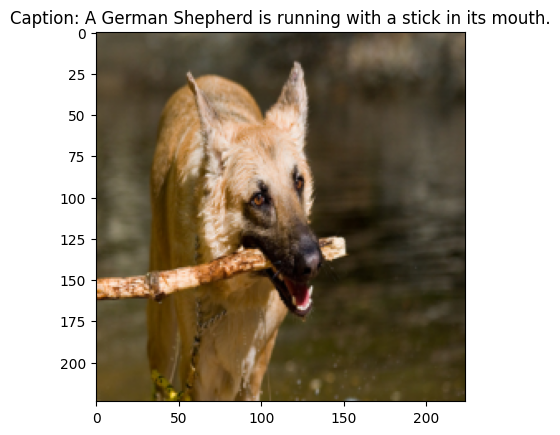

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Create an iterator from the dataloader
data_iter = iter(clip_dataloader)

# Get one batch
batch = next(data_iter) #每个batch:{"image":[...],"caption":[...]}

image = batch["image"][0]  # get one image from the batch
#image.shape: torch.Size([3, 224, 224])
caption = batch["caption"][0]  # get one text from the batch

# Convert the image tensor to a NumPy array and permute dimensions
image_np = np.transpose(image.numpy(), (1, 2, 0))
'''
改变轴的顺序, 原始轴顺序是 (0, 1, 2)，对应于 (channels, height, width)。
新的轴顺序 (1, 2, 0) 意味着：
轴1 (原始的高度) 现在成为轴0 (新的第一维) ,
轴2 (原始的宽度) 现在成为轴1 (新的第二维) ,
轴0 (原始的通道) 现在成为轴2 (新的第三维）。
'''
# Display the image and caption
plt.imshow(image_np)
plt.title(f"Caption: {caption}")
plt.show()

In [ ]:
print(image.shape)
print(batch["caption"])
print(caption)

torch.Size([3, 224, 224])
128
A German Shepherd is running with a stick in its mouth.


In [ ]:
print("example of a caption in a batch:",  batch["caption"][0])
print("number of captions in each batch:",len(batch["caption"]))

example of a caption in a batch: A German Shepherd is running with a stick in its mouth.
number of captions in each batch: 128


In [ ]:
!pip install git+https://github.com/openai/CLIP.git --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 12.9 MB/s eta 0:00:00


logits = np.dot(I_e, T_e.T), 是n*n的矩阵
假设：

```
logits = torch.tensor([
    [2.0, 0.5, 0.3],  # 图像 1 与 文本 1, 2, 3 的相似性
    [0.1, 3.0, 0.1],  # 图像 2 与 文本 1, 2, 3 的相似性
    [0.2, 0.4, 4.0],  # 图像 3 与 文本 1, 2, 3 的相似性
])

labels = torch.tensor([0, 1, 2])  # 正确配对的索引
```


```
logits.transpose(0,1) = [
            [2.0, 0.1, 0.2],  # 文本 1 与 图像 1, 2, 3 的相似性
            [0.5, 3.0, 0.4],  # 文本 2 与 图像 1, 2, 3 的相似性
            [0.3, 0.1, 4.0]]  # 文本 3 与 图像 1, 2, 3 的相似性
```


```
#对每行元素进行softmax操作后，第一行对应的是文本1属于图像1,2,3的概率
softmax_logits = [
    [0.8069, 0.0983, 0.0948],  # 对应文本 1 与 图像 1, 2, 3 的 softmax
    [0.0246, 0.9656, 0.0098],  # 对应文本 2 与 图像 1, 2, 3 的 softmax
    [0.0171, 0.0115, 0.9714]   # 对应文本 3 与 图像 1, 2, 3 的 softmax
]
#label是真实的图像索引，也是目标，根据此选择正确预测值的概率
#每一行选中一个概率，第一行文本1对应真实图像1，选择概率0.8069
selected_probs = [0.8069, 0.9656, 0.9714]
#计算负对数似然，就是损失，最终平均化损失
NLL = [-log(0.8069), -log(0.9656), -log(0.9714)]
NLL = [0.2141, 0.0350, 0.0290]
loss_i = NLL.mean() #loss_i = 0.0927
```

loss_i 计算了每个文本嵌入（作为正确类别）的预测分布和目标分布之间的差异。
目标是减少loss_i,从两方面：
1. 通过最大化正确图像-文本对的相似性。对于正确的配对，真实标签 target_i 为1，我们希望 softmax(input)_i 的值尽可能接近1，这样-log(softmax(input)_i)越小

2. 最小化错误对的相似性来优化模型。真实标签 target_i 为0，我们希望 softmax(input)_i 的值尽可能接近0

通过最小化交叉熵损失，模型会调整其参数，模型学会在特征空间中将正确的图像-文本对拉得更近，使得它们的相似性更高；同时将错误的对拉得更远，使得它们的相似性更低。这种方式使得在预测任务（例如多模态检索）中，正确的图像-文本对更容易被匹配，而错误对被排除的可能性更大。



In [ ]:
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def CLIP_loss(logits: torch.Tensor) -> torch.Tensor:
    '''
    假设我们有 n 个图像和 n 个文本对，logits 的维度为 (n, n)。矩阵中的每个元素表示第 i 个图像嵌入和第 j 个文本嵌入之间的相似性。
    '''
    # Assuming n is the number of classes
    n = logits.shape[1]

    # Create labels tensor
    labels = torch.arange(n).to(device) #也就是索引

    # Calculate cross entropy losses along axis 0 and 1
    loss_i = F.cross_entropy(logits.transpose(0, 1), labels, reduction="mean")
    loss_t = F.cross_entropy(logits, labels, reduction="mean")

    # Calculate the final loss
    loss = (loss_i + loss_t) / 2
    '''
    计算 loss_i 和 loss_t 两个损失的主要目的是确保CLIP模型在多模态（图像和文本）匹配任务中能够同时关注到从图像到文本和从文本到图像两个方向的相似性。
    这是因为图像-文本匹配是一个双向的问题，模型需要在这两个方向上都能有效工作。
    '''
    return loss

def metrics(similarity: torch.Tensor):
    #假设similarity是n*n的矩阵
    y = torch.arange(len(similarity)).to(similarity.device) #生成一个从 0 到 n-1 的整数张量，用于表示正确的匹配对的索引。
    img2cap_match_idx = similarity.argmax(dim=1) #在相似度矩阵的每一行上找到最大值的索引。这个索引表示每个图像最匹配的文本的索引。
    cap2img_match_idx = similarity.argmax(dim=0)

    img_acc = (img2cap_match_idx == y).float().mean()
    cap_acc = (cap2img_match_idx == y).float().mean()

    return img_acc, cap_acc

In [ ]:
import clip
model, preprocess = clip.load("ViT-B/32", device=device)

image = batch["image"].to(device)
true_text = batch["caption"] #包含与图像匹配的正确文本描述（captions）
wrong_text = true_text[::-1] #通过将 true_text 反转顺序生成的错误文本描述。


for captions in [true_text, wrong_text]:
    text = clip.tokenize(captions).to(device)

    # with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    # normalized features
    #对每个图像特征向量进行归一化，使其单位长度为1。
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    #计算文本和图像特征之间的相似性，这里使用矩阵乘法 @ 计算每个文本-图像对之间的相似度（内积）。
    similarity = text_features @ image_features.T
    loss = CLIP_loss(similarity)
    print(loss)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 47.8MiB/s]


tensor(4.7188, device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)
tensor(4.8516, device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)


In [ ]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Projection(nn.Module):
    def __init__(self, d_in: int, d_out: int, p: float = 0.5) -> None:
        super().__init__()
        self.linear1 = nn.Linear(d_in, d_out, bias=False)
        self.linear2 = nn.Linear(d_out, d_out, bias=False)
        self.layer_norm = nn.LayerNorm(d_out)
        self.drop = nn.Dropout(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embed1 = self.linear1(x)
        embed2 = self.drop(self.linear2(F.gelu(embed1)))
        embeds = self.layer_norm(embed1 + embed2)
        return embeds


class VisionEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        base = models.resnet34(pretrained=True)
        d_in = base.fc.in_features
        base.fc = nn.Identity()
        self.base = base
        self.projection = Projection(d_in, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        projected_vec = self.projection(self.base(x))
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len


class TextEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        self.base = AutoModel.from_pretrained(Config.text_model)
        self.projection = Projection(Config.transformer_embed_dim, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        '''
        假设使用BERT模型，BERT 模型的输出是一个包含两个元素的元组，其中第一个元素是所有 token 的隐藏状态张量，
        第二个元素是池化后的输出（如 CLS token 的嵌入）。[0] 选择第一个元素，即隐藏状态张量，
        形状为 (batch_size, sequence_length, hidden_dim)，其中 hidden_dim 是 BERT 的隐藏维度（通常是 768）
        '''
        out = self.base(x)[0]
        '''
        out[:, 0, :]：选择每个输入序列中的 [CLS] token 的嵌入表示。[:, 0, :] 选择了所有样本（批次）的第一个 token（[CLS]）的嵌入，
        结果是形状为 (batch_size, hidden_dim) 的张量。这个表示是整个序列的聚合信息。
        '''
        out = out[:, 0, :]  # get CLS token output

        projected_vec = self.projection(out)
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len

In [ ]:
class Tokenizer:
    def __init__(self, tokenizer: BertTokenizer) -> None:
        self.tokenizer = tokenizer
    '''
    self.tokenizer(x, ...)：使用 BertTokenizer 对输入文本 x 进行分词和编码。
    max_length=Config.max_len：设置最大序列长度为 Config.max_len。如果文本长度超过这个值，会进行截断；如果文本长度不足，会进行填充。
    truncation=True：启用文本截断。超过 max_length 的部分会被截断。
    padding=True：启用填充。短于 max_length 的文本会填充到 max_length。
    return_tensors="pt"：将输出转换为 PyTorch 张量格式。
    '''
    def __call__(self, x: str) -> AutoTokenizer:
        return self.tokenizer(
            x, max_length=Config.max_len, truncation=True, padding=True, return_tensors="pt"
        )


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image = batch["image"].to(device)
true_text = batch["caption"]
wrong_text = true_text[::-1]

vision_encoder = VisionEncoder(Config.embed_dim).to(device) #Resnet34
caption_encoder = TextEncoder(Config.embed_dim).to(device)  #distilbert-base-multilingual-cased
tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_model))

for captions in [true_text, wrong_text]:
    text = tokenizer(captions).to(device)

    # with torch.no_grad():
    image_features = vision_encoder(image)
    text_features = caption_encoder(text["input_ids"])

    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    similarity = text_features @ image_features.T
    loss = CLIP_loss(similarity)
    print(loss)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 95.2MB/s]


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor(4.8527, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.8475, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from typing import List, Tuple


class CustomModel(nn.Module):
    def __init__(self, lr: float = 1e-3) -> None:
        super().__init__()
        self.vision_encoder = VisionEncoder(Config.embed_dim)
        self.caption_encoder = TextEncoder(Config.embed_dim)
        self.tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_model, use_fast=False))
        self.lr = lr
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def forward(self, images, text):
        text = self.tokenizer(text).to(self.device)

        image_embed = self.vision_encoder(images)
        caption_embed = self.caption_encoder(text["input_ids"])
        similarity = caption_embed @ image_embed.T

        loss = CLIP_loss(similarity)
        img_acc, cap_acc = metrics(similarity)
        return loss, img_acc, cap_acc

In [ ]:
# Create an instance of your model
model = CustomModel().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define optimizer
optimizer = torch.optim.Adam([
    {'params': model.vision_encoder.parameters()},
    {'params': model.caption_encoder.parameters()}
], lr=model.lr)

In [ ]:
start_epoch = 0
num_epochs = 3

batch_zero = True
for epoch in range(start_epoch, num_epochs):
    model.train()
    for batch in clip_dataloader:
        image = batch["image"].to(device)
        text = batch["caption"]
        # images, text = batch
        loss, img_acc, cap_acc = model(image, text)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_zero:
          #打印第一个批次的损失值，便于查看模型是否正确训练和调试。
          print(f"Epoch [{0}/{num_epochs}], Batch Loss: {loss.item()}")
          batch_zero = False


    # Print training statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Batch Loss: {loss.item()}")

print("Training complete.")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0/3], Batch Loss: 4.853445053100586
Epoch [1/3], Batch Loss: 3.832379102706909
Epoch [2/3], Batch Loss: 3.7962512969970703
Epoch [3/3], Batch Loss: 3.8119378089904785
Training complete.
